# Examen Final - Temas Avanzados en Computación
##### Integrantes:
* 20110324        Zorrilla Maguiña, Louis Javier
* 20154373	      Ormeño Meza, Ruben Aaron
* 20160236	      Ulloa Coronado, Adrian Eduardo

## 0. Carga de librerías empleadas

In [3]:
from PIL import Image
import PIL
import glob
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
from imgaug import augmenters as iaa
import imgaug as ia
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import warnings

ModuleNotFoundError: No module named 'torch'

## 1. Organización de datos

### Limpiar datos previos

In [2]:
!sudo rm -rf /home/ubuntu/tac/Mi3_Aligned
!unzip /home/ubuntu/tac/Dataset.zip > out.log

### Crear las nuevas imagenes a partir de las referencias

(explicar por qué esto es necesario)

In [27]:
##https://stackoverflow.com/questions/12570859/how-to-show-pil-images-on-the-screen/12571366

root = '/home/ubuntu/tac/Mi3_Aligned'
cleanFilenames = sorted(glob.glob(root + '/*/*Reference.jpg'))
noisyFilenames = sorted(glob.glob(root + '/*/*Noisy.jpg'))

matrix = 250 ###tamaño del crop
sample = 20  ###cantidad de crops por imagen
for i in range(len(cleanFilenames)):   ##recorre todos los archivos con formato 'root/*.jpg'
    cleanImg = Image.open(cleanFilenames[i])
    noisyImg = Image.open(noisyFilenames[i])
    x, y = cleanImg.size
    for j in range(sample):
        xT= randrange(0, x - matrix)
        yT= randrange(0, y - matrix)
        xP= randrange(0, x - matrix)
        yP =randrange(0, y - matrix)
        ##crea un crop y lo guarda en la misma ubicación de la imagen padre
        cleanImg.crop((xT, yT, xT + matrix, yT + matrix)).save(cleanFilenames[i].split('.')[0] + 'T' + str(j).zfill(2) + '.jpg')
        noisyImg.crop((xT, yT, xT + matrix, yT + matrix)).save(noisyFilenames[i].split('.')[0] + 'T' + str(j).zfill(2) + '.jpg')
        cleanImg.crop((xP, yP, xP + matrix, yP + matrix)).save(cleanFilenames[i].split('.')[0] + 'P' + str(j).zfill(2) + '.jpg')
        noisyImg.crop((xP, yP, xP + matrix, yP + matrix)).save(noisyFilenames[i].split('.')[0] + 'P' + str(j).zfill(2) + '.jpg')


In [28]:
class MiDataset(torch.utils.data.Dataset):
  def __init__(self, root, tform=None, imgloader=Image.open, set_type='train'):
    super(MiDataset, self).__init__()
    
    self.root = root
    if set_type=='train':
        self.filenames = sorted(glob.glob(root + '/*/*ReferenceT[0-9][0-9].jpg'))
    elif set_type=='target':
        self.filenames = sorted(glob.glob(root + '/*/*NoisyT[0-9][0-9].jpg'))
    elif set_type=='test':
        self.filenames = sorted(glob.glob(root + '/*/*NoisyP[0-9][0-9].jpg'))
    elif set_type=='test-reference':
        self.filenames = sorted(glob.glob(root + '/*/*ReferenceP[0-9][0-9].jpg'))
            
    self.tform = tform
    self.imgloader = imgloader
    
  def __len__(self):
    return len(self.filenames)
  
  def __getitem__(self, i):
    out = self.imgloader(self.filenames[i])
    if self.tform:
      out = self.tform(out)
    return out

doc_train_dataset = MiDataset(root=root,tform=T.Compose([T.ToTensor()]), set_type='train')
doc_train_loader = torch.utils.data.DataLoader(doc_train_dataset, batch_size=4)

doc_target_dataset = MiDataset(root=root,  tform=T.Compose([T.ToTensor()]), set_type='target')
doc_target_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)

doc_test_dataset = MiDataset(root=root,   tform=T.Compose([T.ToTensor()]), set_type='test')
doc_test_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)

doc_test_ref_dataset = MiDataset(root=root,   tform=T.Compose([T.ToTensor()]), set_type='test-reference')
doc_test_ref_loader = torch.utils.data.DataLoader(doc_target_dataset, batch_size=4)


In [29]:
len(doc_test_ref_dataset)

1600

## 2. Creación y configuración de modelo de aprendizaje

### Denoising autoencoder
Para resolver este problema se utilizará un denoising autoencoder, ya que es el modelo apropiado para reconstruir data 
Referencia: https://towardsdatascience.com/denoising-autoencoders-explained-dbb82467fc2

In [30]:
class NoiseRemoval(nn.Module):
  def __init__(self):
    super(NoiseRemoval, self).__init__()
    
    self.encoder = nn.Sequential(nn.Conv2d(3, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(2, 2))
    
    self.decoder = nn.Sequential(nn.Conv2d(250, 250, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.Upsample(scale_factor=2),
                                nn.Conv2d(250, 3, kernel_size=3, padding=1))
    
  def forward(self,x):
    return self.decoder(self.encoder(x))
  
net = NoiseRemoval()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

### Estrategia de entrenamiento
Se emplearán un total de 1600 pares de sub-imágenes extraídas aleatoriamente de los 80 pares disponibles, y se entrenará durante 20 épocas

In [ ]:
from datetime import timedelta
import time

start= time.time()

epochs = 20
for epoch in range(epochs):
  for x,y in zip(doc_train_loader, doc_target_loader):
    output = net(x)
    loss = criterion(output, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, loss.item()))
  elapsed= time.time() - start
  print(str(timedelta(seconds=elapsed)))
  start= time.time()

Epoch [1/20], Loss: 0.0013
0:08:03.913979
Epoch [2/20], Loss: 0.0012
0:08:03.362643
Epoch [3/20], Loss: 0.0013
0:08:02.778376


## 3. Experimentación

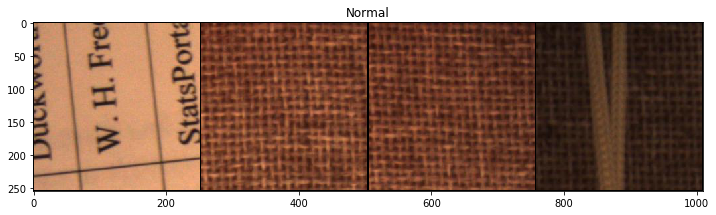

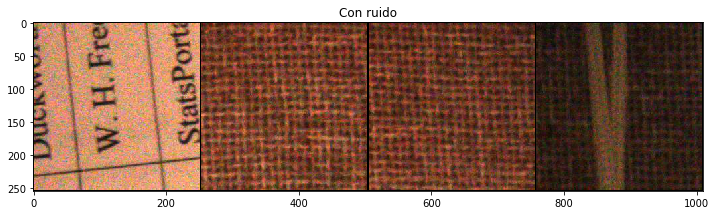

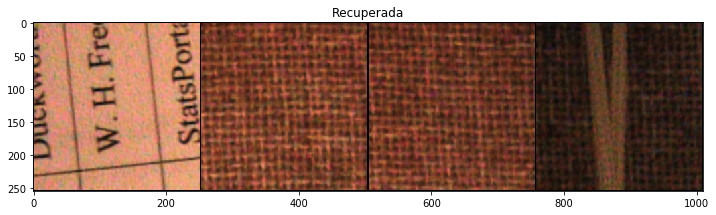

In [25]:
data = next(iter(doc_test_loader))

with torch.no_grad():
  out = net(data)


gridX = torchvision.utils.make_grid(next(iter(doc_train_loader)), nrow=4)

plt.figure(figsize=(12, 12))
plt.imshow(gridX.permute(1, 2, 0))
plt.title('Normal')
plt.show()

grid1 = torchvision.utils.make_grid(data, nrow=4)

plt.figure(figsize=(12, 12))
plt.imshow(grid1.permute(1, 2, 0))
plt.title('Con ruido')
plt.show()


grid2 = torchvision.utils.make_grid(out.cpu(), nrow=4)
plt.figure(figsize=(12, 12))
plt.imshow(grid2.permute(1, 2, 0))
plt.title('Recuperada')
plt.show()

## 4. Discusión de Resultados y Conclusiones

In [26]:
torch.save(net, '/home/ubuntu/tac/modelo50.torch')